# Bias in AI: Implementation Notebook

This notebook contains the code to reproduce figures, training results and fairness methods detailed in the paper. All cells should be run once and sequentially. Headers mirror the headers in the paper for convenience.

## Analysis

<ipython-input-3-3869003931ec>:7: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



### Non-white - Female

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week,high_income
Mean,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,37.04744,547.303429,44.12729,36.871771,0.070925
Variance,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,160.132617,30597599.484955,83753.287831,102.304508,0.065926
Mode,Private,HS-grad,Never-married,Adm-clerical,Unmarried,Black,Female,United-States,N/A,N/A,N/A,N/A,N/A
2nd Mode,?,Some-college,Divorced,Other-service,Not-in-family,Asian-Pac-Islander,N/A,Philippines,N/A,N/A,N/A,N/A,N/A
3rd Mode,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,Amer-Indian-Eskimo,N/A,?,N/A,N/A,N/A,N/A,N/A


### Non-white - Male

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week,high_income
Mean,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,37.828746,1041.288226,85.202217,40.663609,0.219037
Variance,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,163.060527,54933652.358959,156679.30632,130.056587,0.171125
Mode,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,Black,Male,United-States,N/A,N/A,N/A,N/A,N/A
2nd Mode,Local-gov,Some-college,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,N/A,?,N/A,N/A,N/A,N/A,N/A
3rd Mode,Self-emp-not-inc,Bachelors,Divorced,Prof-specialty,Own-child,Amer-Indian-Eskimo,N/A,Philippines,N/A,N/A,N/A,N/A,N/A


### White - Female

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week,high_income
Mean,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,36.811618,573.610391,65.390535,36.296691,0.118954
Variance,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,205.322916,22687423.10325,124137.004854,148.61929,0.104816
Mode,Private,HS-grad,Never-married,Adm-clerical,Not-in-family,White,Female,United-States,N/A,N/A,N/A,N/A,N/A
2nd Mode,?,Some-college,Divorced,Other-service,Own-child,N/A,N/A,Mexico,N/A,N/A,N/A,N/A,N/A
3rd Mode,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Unmarried,N/A,N/A,?,N/A,N/A,N/A,N/A,N/A


### White - Male

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week,high_income
Mean,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,39.652498,1368.674455,102.261343,42.668822,0.317565
Variance,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,180.526866,71281389.712927,188492.245314,148.709071,0.216729
Mode,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,N/A,N/A,N/A,N/A,N/A
2nd Mode,Self-emp-not-inc,Some-college,Never-married,Exec-managerial,Not-in-family,N/A,N/A,Mexico,N/A,N/A,N/A,N/A,N/A
3rd Mode,Local-gov,Bachelors,Divorced,Prof-specialty,Own-child,N/A,N/A,?,N/A,N/A,N/A,N/A,N/A


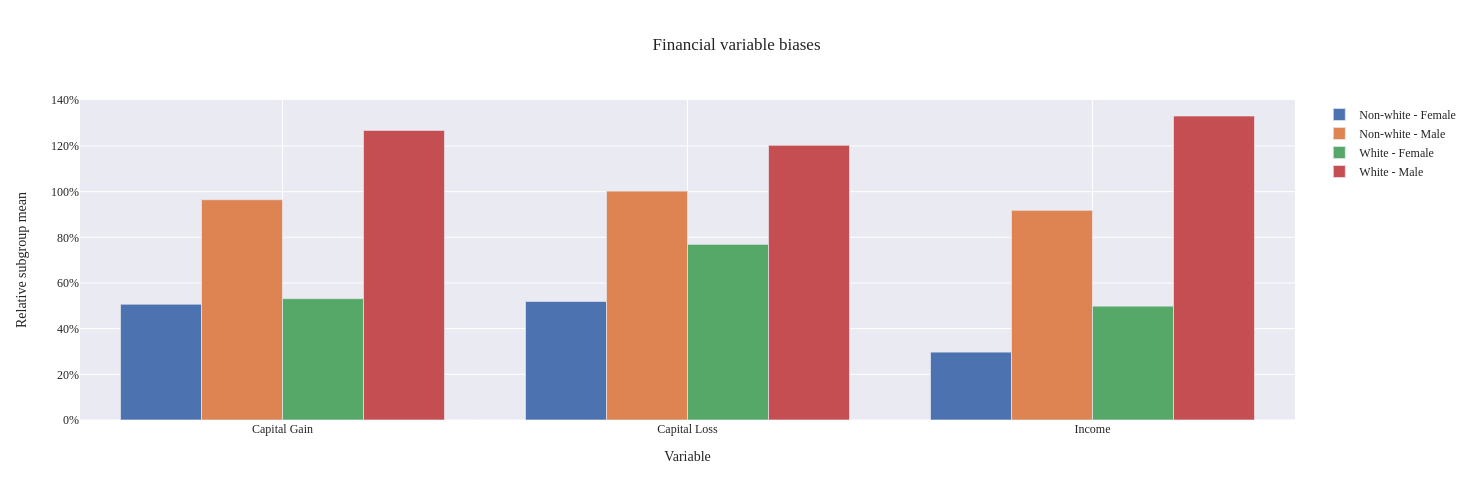

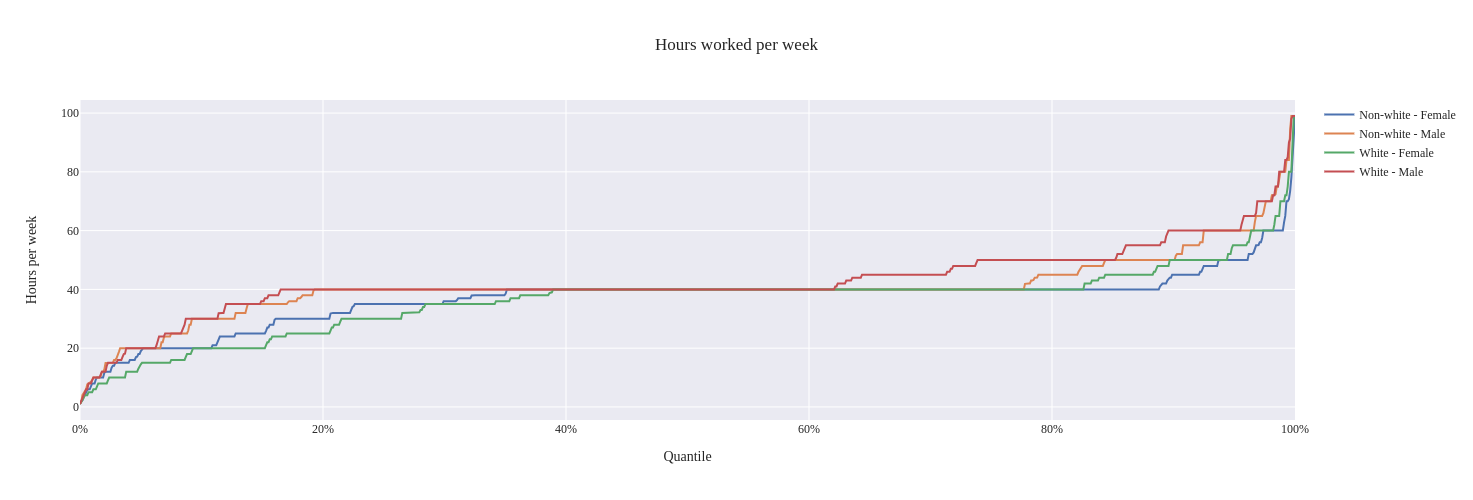

In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import microdf as mdf

df = pd.read_csv("adult.data", header=None, delimiter=", ")

df.columns = [
    "age",
    "workclass",
    "weight",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]
WEIGHT_ADJ = 263400000 / df.weight.sum()
df = mdf.MicroDataFrame(df, weights=df.weight * WEIGHT_ADJ)

df["race_binary"] = np.where(df.race == "White", "White", "Non-white")
df["high_income"] = df.income == ">50K"

df["group"] = df.race_binary + " - " + df.sex

def format_fig(fig, title=None, x_title=None, y_title=None, pct=True, legend=False):
    fig.update_layout(
        title=title, 
        width=650, 
        height=500, 
        xaxis_title=x_title, 
        yaxis_title=y_title,
        template="seaborn",
        font_family="Computer Modern",
        showlegend=legend,
    )
    if pct:
        fig.update_layout(yaxis_tickformat="%")
    return fig

format_fig(px.bar((df.income == " >50K").groupby(df.group).mean().sort_values()), "Percentage earning over $50k by race-gender group").write_image("images/percent_rich.pdf")

CATEGORICAL = [
    "workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country",
]
CONTINUOUS = [
    "age", "capital-gain", "capital-loss", "hours-per-week",
]
OUTPUT = [
    "high_income",
]
SENSITIVE = [
    "race", "sex", "group",
]

from IPython.display import display, Markdown

for group, gdf in df.groupby("group"):
    summary = pd.DataFrame()
    for col in CATEGORICAL:
        values = list(gdf[col].value_counts().index[:3])
        while len(values) < 3:
            values += ["N/A"]
        summary[col] = ["N/A", "N/A", *values]
    for col in CONTINUOUS + OUTPUT:
        summary[col] = [gdf[col].mean(), gdf[col].var(), "N/A", "N/A", "N/A"]
    summary.index = ["Mean", "Variance", "Mode", "2nd Mode", "3rd Mode"]
    display(Markdown(f"### {group}"))
    display(summary)
    
fig = go.Figure()

for i, gdf in df.groupby("group"):
    fig.add_trace(go.Bar(x=["Capital Gain", "Capital Loss", "Income"], y=[gdf["capital-gain"].mean() / df["capital-gain"].mean(), gdf["capital-loss"].mean() / df["capital-loss"].mean(), gdf["high_income"].mean() / df["high_income"].mean()], name=i))

fig = format_fig(fig, "Financial variable biases", "Variable", "Relative subgroup mean", pct=True, legend=True)
fig.show()
fig.write_image("images/fin_bias.pdf")

fig = go.Figure()

for i, gdf in df.groupby("group"):
    quantiles = gdf["hours-per-week"].quantile(np.linspace(0, 1, 1000))
    fig.add_trace(go.Scatter(mode="lines", x=quantiles.index, y=quantiles.values, name=i))

fig = format_fig(fig.update_layout(xaxis_tickformat="%"), "Hours worked per week", "Quantile", "Hours per week", pct=False, legend=True)
fig.show()
fig.write_image("images/hours_bias.pdf")

## Conventional Implementation

In [38]:
X_CAT = [
    "workclass", 
    "education", 
    "marital-status", 
    "occupation", 
    "relationship", 
    "native-country",
]
X_CON = [
    "age", 
    "capital-gain", 
    "capital-loss", 
    "hours-per-week", 
]
X = pd.get_dummies(df[X_CAT + X_CON], columns=X_CAT)
X = X[[col for col in X.columns if X[col].mean() > 0.001]].values
Y = df[["high_income"]].values
S = pd.get_dummies(df[["group"]]).values

random = np.random.rand(len(df))
train = random < 0.8
val = ~train * random < 0.9
test = ~train * ~val

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input

inp = Input(shape=(79,))
h = Dense(64, activation="relu")(inp)
h = Dropout(0.05)(h)
h = Dense(16, activation="relu")(h)
h = Dropout(0.05)(h)
out = Dense(1, activation="sigmoid")(h)
conventional = Model(inp, out)
conventional.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = conventional.fit(X[train], Y[train], sample_weight=df.weight[train], validation_data=(X[val], Y[val]), epochs=1024, batch_size=33000)

Epoch 1/1024
1/1 [==============================] - 0s 427ms/step - loss: 116285.0156 - accuracy: 0.2510 - val_loss: 10.5361 - val_accuracy: 0.2544
Epoch 2/1024
1/1 [==============================] - 0s 37ms/step - loss: 109397.3906 - accuracy: 0.2678 - val_loss: 4.4622 - val_accuracy: 0.2746
Epoch 3/1024
1/1 [==============================] - 0s 44ms/step - loss: 76261.0938 - accuracy: 0.2929 - val_loss: 6.6949 - val_accuracy: 0.2870
Epoch 4/1024
1/1 [==============================] - 0s 42ms/step - loss: 74370.5312 - accuracy: 0.3092 - val_loss: 3.8879 - val_accuracy: 0.3363
Epoch 5/1024
1/1 [==============================] - 0s 41ms/step - loss: 73450.5078 - accuracy: 0.3468 - val_loss: 5.1080 - val_accuracy: 0.3648
Epoch 6/1024
1/1 [==============================] - 0s 42ms/step - loss: 70371.2031 - accuracy: 0.3665 - val_loss: 3.2463 - val_accuracy: 0.4190
Epoch 7/1024
1/1 [==============================] - 0s 43ms/step - loss: 62096.8320 - accuracy: 0.4113 - val_loss: 3.8975 - va

In [39]:
conventional.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 79)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                5120      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 17        
Total params: 6,177
Trainable params: 6,177
Non-trainable params: 0
_________________________________________________________

In [41]:
table=pd.DataFrame(columns=["Name","Type","Shape","Parameters"])
for layer in conventional.layers:
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape, "Parameters": len(layer.trainable_variables}, ignore_index=True)

In [44]:
print(table.to_latex())

\begin{tabular}{llll}
\toprule
{} &        Name &        Type &         Shape \\
\midrule
0 &     input\_8 &  InputLayer &  [(None, 79)] \\
1 &    dense\_21 &       Dense &    (None, 64) \\
2 &  dropout\_14 &     Dropout &    (None, 64) \\
3 &    dense\_22 &       Dense &    (None, 16) \\
4 &  dropout\_15 &     Dropout &    (None, 16) \\
5 &    dense\_23 &       Dense &     (None, 1) \\
\bottomrule
\end{tabular}

